# Лабораторная работа № 4



### Автоэнкодеры

Загрузим раcширение для tensorboard: 

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

Автоэнкодер состоит из двух частей - энкодера и декодера. Задача энкодера сжать входные данные (обычно эти данные обозначают  как **x**) с минимально возможной потерей данных и получить вектор (обычно этот сжатый вектор обозначают  как **z**).

Задача декодера обратная: из сжатого вектора восстановить из **z** исходные данные.

Традиционно автоэнкодеры использовали в качестве способа уменьшения размерности и отображения их на графиках 

В этой лабораторной работе будем создавать [вариационный автоэнкодер](https://arxiv.org/pdf/1312.6114). На рисунке ниже показана его схема

![Вариационный автоэнкодер, схема](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png)

Отличие вариационного автоэнкодера от обычного заключается в способе получения вектора **z**. В вариационном автоэнкодере предполагается, что данные можно охарактеризовать несколькими переменные, которые принадлежат некоторому вероятностному распределению. Зная распределение, можно будет получать (генерировать) данные исключительно из вектора **z**.


Выше мы создали наши энкодер и декодер. Далее создадим модель, которая будет использовать их и использовать репараметризацию для получения ветора **z**.

Репараметризацию необходимо делать т.к. операция извлечения примера из распределения не дифференцируема. Ниже написан этот способ в виде математической формулы

![alt text](https://cdn-images-1.medium.com/max/1600/1*CEUvzm7vNdSh7cCBgcWxUA.png)

,где $\epsilon$ - случайный шум из нормального распределения;

$\mu$ - среднее значение, полученное от энкодера;

$\sigma$ - стандартное отклонение, полученное от энкодера;




### Обучение

Наша модель готова к обучению. Далее необходимо выбрать оптимизатор, создать функцию для расчета потери для обучения, создать функцию для расчета градиентов и настройки весов.

#### Функция потери

Функция потери состоит из двух  частей:

1.   потеря восстановления изображения (бинарная кросс-энтропия)
2.   Дивергенция Кульбака-Либлера ([KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence))

Если с первым мы сталкивались и использовали, то вторая часть нашей потери вызывает недоумение.

 Дивергенция Кульбака-Либлера пришла из теории информации и показывает как близки два распределения друг к другу. Она положительно определена и если $D_{KL}(p||q) = 0$ значит распределения равны друг к другу. Вычисляется она по формуле:
 
 $$
 D_{KL} = - \int{p(x)log\frac{p(x)}{q(x)}}dx
 $$
 
 Еще одно из свойств данной метрики - $D_{KL}(p||q) \ne D_{KL}(q||p) $
 
 В нашем случае  $p(x)$ - распределение от энкодера, а $q(x)$ - нормальное распределение со мат ожиданием равном нулю и стандартным отклонением - 1. И в результате подстановки значений получим следующую формулу для вычисления потери:
 $$
 \frac{1}{2}[\sum^z_{i=1}\mu^2_i+\sum^z_{i=1}\sigma_i^2−\sum^z_{i=1}log(\sigma_i) - 1]
 $$



##### Tensorboard и Colab

В Tensorflow 2.0 добавили расширение для Jupyter Notebook, которая встраивает в вывод ячейки Tensorboard. Для ее вызова необходимо выполнить:
```
# Загрузает расширение в Notebook
%load_ext tensorboard
....
# Открывает в выводе ячейки tensorboard
%tensorboard --logdir logs/
```

В PyTorch существует расширение для работы с тензорбордом. Документацию можно посмотреть [здесь](https://pytorch.org/docs/stable/tensorboard.html)


# Задание



1.   Создать вариационный автоэнкодер с использованием сверток ([Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)) в энкодере (слои отвечающие за среднее и отклонение остаются полносвязными), и с развертками ([Conv2dTranspose](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) в декодере. Размерность скрытого вектора равна двум (1 Балл)

1.  Создать вариационный автоэнкодер с использованием сверток (Conv2d) в энкодере (слои отвечающие за среднее и отклонение остаются полносвязными), и с развертками ([Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample), [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)) в декодере. Размерность скрытого вектора равна двум. [Подробнее](https://distill.pub/2016/deconv-checkerboard/) (1 Балл)

2.   Создать сетку из 25 изображений, где по оси Х изменяется значение первого элемента **z**, а по оси Y - второго элемента **z** (2 Балла) Пример изображения на базе данных MNIST


In [ ]:
#1

In [3]:
import torch
import torch.nn as nn
import datetime as dt
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import torch.nn.functional as F

In [4]:

BATCH_SIZE = 500

transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

class FirstEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(FirstEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Sequential(                                           
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=2, padding=1),      
             nn.BatchNorm2d(32),
             nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),          
             nn.BatchNorm2d(32),
             nn.ReLU())
            

        self.dropout = nn.Dropout(0.5)
        self.fc_mu = nn.Sequential(
            nn.Linear(32 * 49, self.latent_dim),
            
        )
        self.fc_var = nn.Sequential(
            nn.Linear(32 * 49, self.latent_dim),
            
        )


    def forward(self, x):
        
        x = self.conv1(x)
        x = x.reshape(-1, 32*49)
        mu = self.fc_mu(x)
        logvar = self.fc_var(x)
        return mu, logvar
class FirstDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(FirstDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*49),
          
        )
        self.conv1 = nn.Sequential(
           nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),       
           nn.BatchNorm2d(32),
              nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),     
        )

        self.dropout = nn.Dropout(0.5)       
        
        
    def forward(self, x):
        x = self.fc_decoder(x)
        x = x.reshape(-1,32,7,7)
        x = self.conv1(x)
        
        return x

class VAE(nn.Module):
        def __init__(self, latent_dim):
            super(VAE, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = FirstEncoder(latent_dim)
            self.decoder = FirstDecoder(latent_dim)

        def forward(self, x):
            mu, logvar = self.encoder(x)
            z = self.reparametrize(mu, logvar)
            x_hat = self.decoder(z)
            return x_hat, mu, logvar
    
    # Функция выполняющая репараметризацию
        def reparametrize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu

        def sample(self, num_samples) -> torch.Tensor:
            z = torch.randn(num_samples,
                            self.latent_dim)

            z = z.to(self.encoder.fc_mu[0].weight.device)

            samples = torch.sigmoid(self.decoder(z))

            return samples

len(train_dataset) = 60000
len(val_dataset) = 10000


In [5]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
%reload_ext tensorboard
%tensorboard --logdir 'logs'

Reusing TensorBoard on port 6006 (pid 19732), started 0:00:00 ago. (Use '!kill 19732' to kill it.)

In [8]:
epochs = 15
latent_dim = 2
num_examples_to_generate = 16
model = VAE(latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)

In [9]:
summary_writer = SummaryWriter(comment = 'With ConvTranspose in the decoder part')

    
def generate_and_save_images(model, epoch, file_writer):
    '''
    Генерирует 16 примеров и записывает их в file_writer для
    визуализации в tensorboard
    '''
    with torch.no_grad():
        model.eval()
        predictions = model.sample(16).reshape(-1,1,28,28)
        #print('!', predictions.shape)
        #print(predictions)
    images = torchvision.utils.make_grid(predictions, 4)
    file_writer.add_image("samples", images, global_step=epoch)

    
generate_and_save_images(model, 0, summary_writer)


In [11]:
def compute_loss(model, x):
    x_hat, mu, logvar = model(x)
    ## сигмоида встроена в функцию потери
    recons_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum') 

    kld_loss = -0.5 * (1 + logvar - mu ** 2 - logvar.exp()).sum()

    return recons_loss, kld_loss

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    totat_len = len(train_dataloader)
    for step, train_x in enumerate(train_dataloader):
        recon_loss, kld_loss = compute_loss(model, train_x[0].to(device))
        summary_writer.add_scalar('train/recon_loss', recon_loss, global_step = epoch * totat_len + step)
        summary_writer.add_scalar('train/kld_loss', kld_loss, global_step = epoch * totat_len + step)
        loss = recon_loss + kld_loss
        # break
        summary_writer.add_scalar('train/loss', loss, global_step = epoch * totat_len + step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # break
    if epoch % 1 == 0:
        losses = []
        model.eval()
        for test_x in val_dataloader:
            recon_loss, kld_loss = compute_loss(model, test_x[0].to(device))
            loss = recon_loss + kld_loss
            losses.append(loss)
        summary_writer.add_scalar('test/loss', torch.stack(losses).mean(), global_step=epoch)
        generate_and_save_images(model, epoch, summary_writer)
    scheduler.step()
    
summary_writer.close()

  0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
print("len(val_dataset) =", len(val_dataset))

BATCH_SIZE = len(val_dataset)
val_dataloader= torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model.eval()
for test_x in val_dataloader:
    x_hat, mu, logvar = model(test_x[0])
    labels = test_x[1]
print(mu)  
print('end')
print(logvar)

len(val_dataset) = 10000
tensor([[-1.0163,  0.2269],
        [-0.5112,  0.4383],
        [-0.7373, -0.3677],
        ...,
        [-0.7995,  0.2947],
        [-1.1522, -0.8314],
        [-1.3592, -0.0607]], grad_fn=<AddmmBackward0>)
end
tensor([[-5.2451, -4.9243],
        [-5.1768, -5.1635],
        [-5.1556, -4.5900],
        ...,
        [-5.2432, -4.7431],
        [-5.0529, -4.3416],
        [-4.6339, -4.9891]], grad_fn=<AddmmBackward0>)


In [13]:
mu_save = mu
logvar_save = logvar
labels_save = labels
lab = labels_save.numpy()
mu_numpy = mu.detach().numpy()

In [14]:
torch.save(model, 'models/model_mnist_convtranspose.pth')

In [15]:
mu_numpy.shape

(10000, 2)

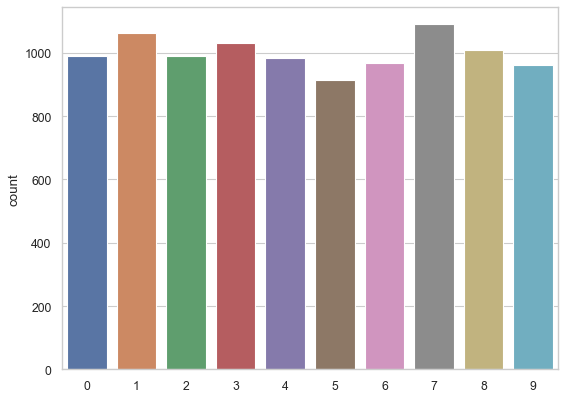

In [16]:
col = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(x=lab);

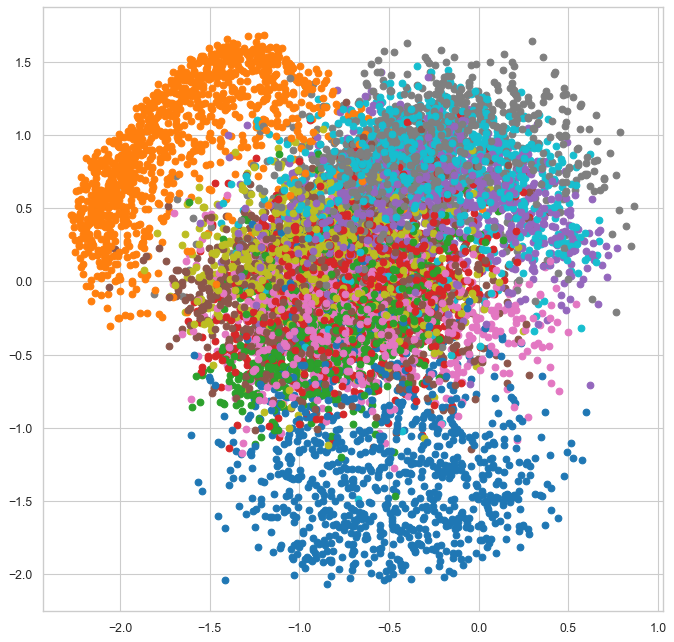

In [17]:
plt.figure(figsize=(10, 10), dpi=80)
for i, point in enumerate(mu_numpy[:]):
    nom = lab[i]
    plt.scatter(point[0],point[1],color = col[nom])
plt.show()

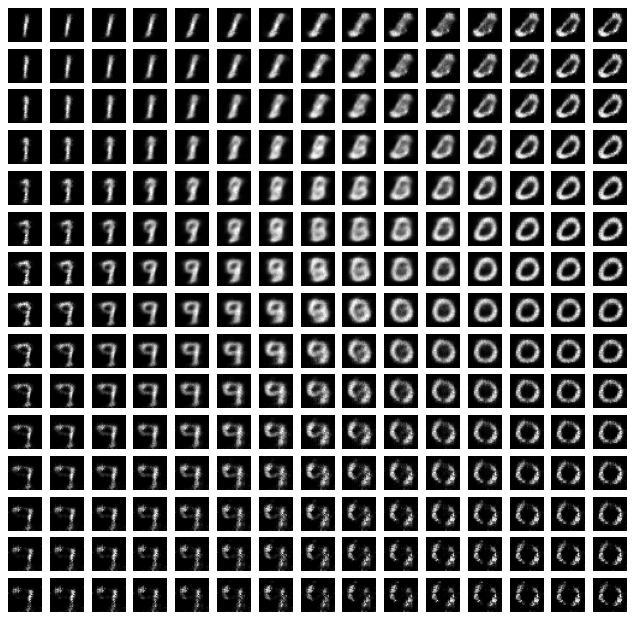

In [18]:
num = 0
N = 15
plt.figure(figsize=(10, 10), dpi=80)
for i in np.linspace(-2, 2, N, endpoint=True):
    for j in np.linspace(2, -2, N, endpoint=True):
        num += 1
        ax = plt.subplot(N, N, num)
        samples = torch.sigmoid(model.decoder(torch.Tensor([[i,j]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')

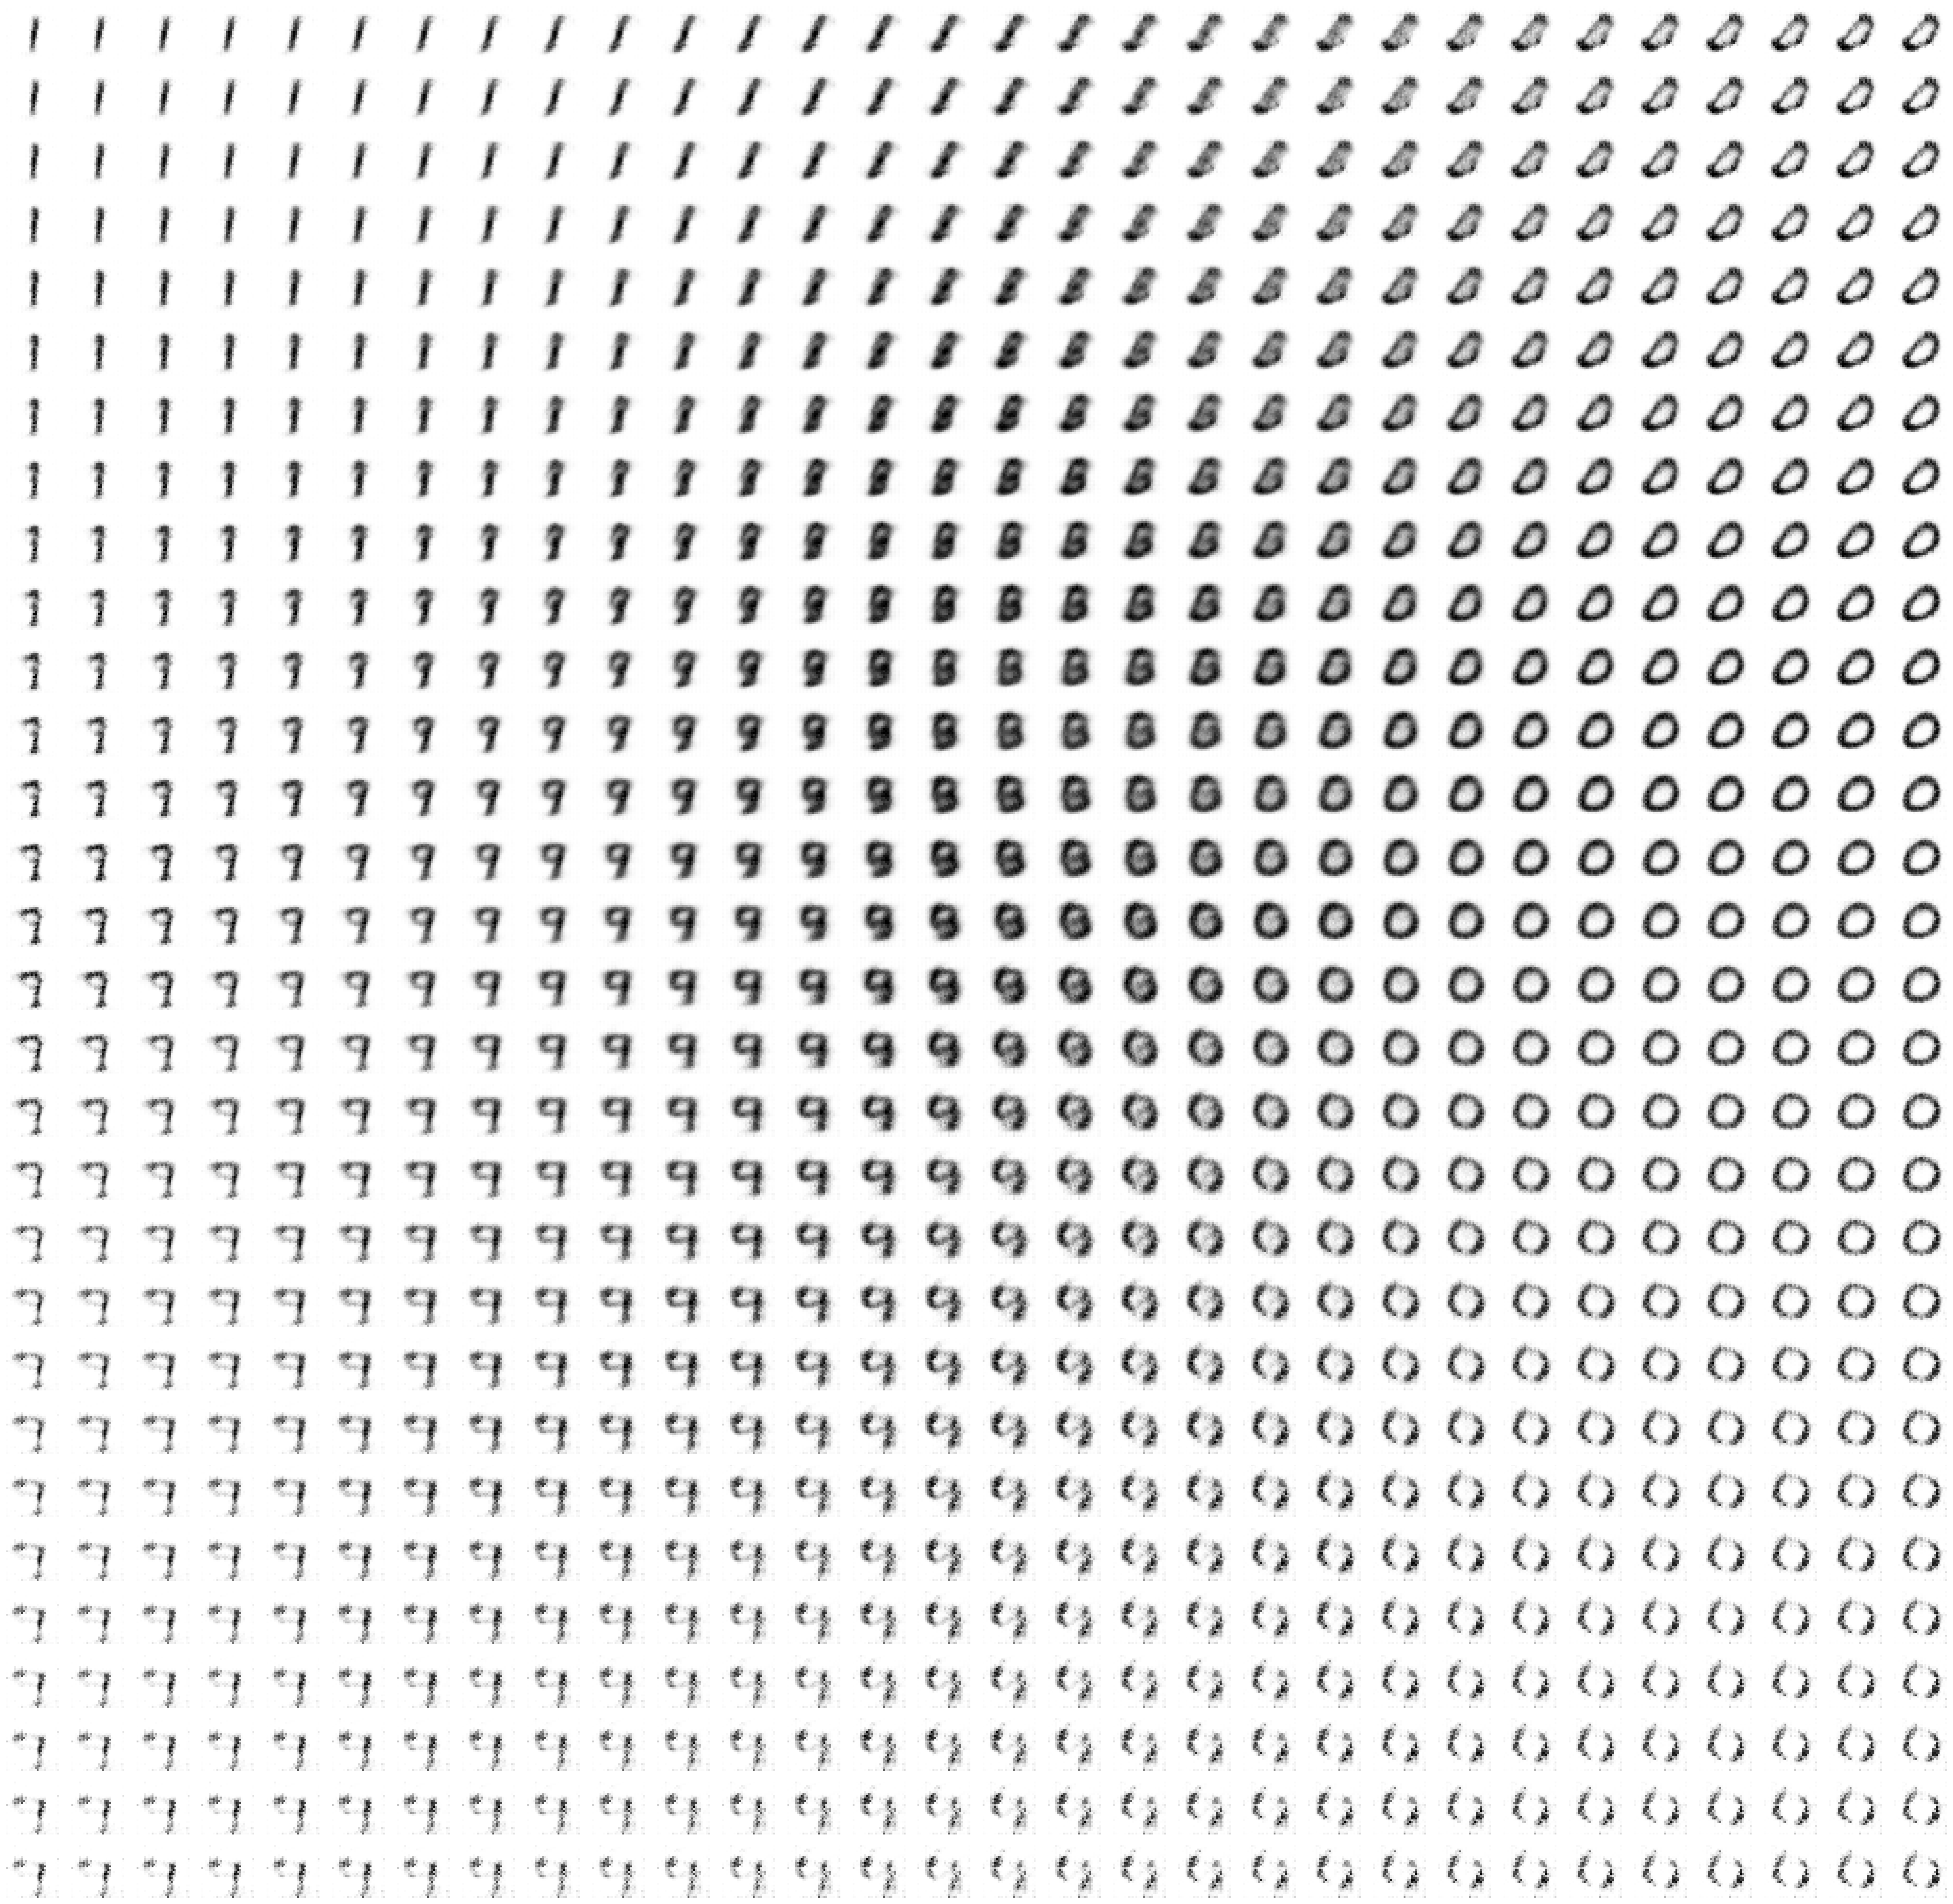

In [19]:
num = 0
N = 30
plt.figure(figsize=(30, 30), dpi=200)
for i in np.linspace(-2, 2, N, endpoint=True):
    for j in np.linspace(2, -2, N, endpoint=True):
        num += 1
        ax = plt.subplot(N, N, num)
        samples = 1 - torch.sigmoid(model.decoder(torch.Tensor([[i,j]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')

In [20]:
#2

In [22]:
BATCH_SIZE = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    ])


train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Sequential(                                           
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=2, padding=1),      
             nn.BatchNorm2d(32),
             nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),          
             nn.BatchNorm2d(32),
             nn.ReLU())
            

        self.dropout = nn.Dropout(0.5)
        self.fc_mu = nn.Sequential(
            nn.Linear(32 * 49, self.latent_dim),
            
        )
        self.fc_var = nn.Sequential(
            nn.Linear(32 * 49, self.latent_dim),
            
        )


    def forward(self, x):
        
        x = self.conv1(x)
        x = x.reshape(-1, 32*49)
        mu = self.fc_mu(x)
        logvar = self.fc_var(x)
        return mu, logvar
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*49))
        
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)       
        self.bn1 = nn.BatchNorm2d(32)
        self.act = nn.ReLU() 
        self.conv2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)   
        
        
    def forward(self, x):
        x = self.fc_decoder(x)
        x = x.reshape(-1,32,7,7)
        x = F.upsample_bilinear(x, size=14)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = F.upsample_bilinear(x, size=28)
        x = self.conv2(x)
        
        
        return x

class VAE(nn.Module):
        def __init__(self, latent_dim):
            super(VAE, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = Encoder(latent_dim)
            self.decoder = Decoder(latent_dim)

        def forward(self, x):
            mu, logvar = self.encoder(x)
            z = self.reparametrize(mu, logvar)
            x_hat = self.decoder(z)
            return x_hat, mu, logvar
    
    # Функция выполняющая репараметризацию
        def reparametrize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu

        def sample(self, num_samples) -> torch.Tensor:
            z = torch.randn(num_samples,
                            self.latent_dim)

            z = z.to(self.encoder.fc_mu[0].weight.device)

            samples = torch.sigmoid(self.decoder(z))

            return samples

len(train_dataset) = 60000
len(val_dataset) = 10000


In [23]:
epochs = 15
latent_dim = 2
num_examples_to_generate = 16
model = VAE(latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)

In [24]:
summary_writer = SummaryWriter(comment = ' With Upsampling in the decoder part')

    
def generate_and_save_images(model, epoch, file_writer):
    '''
    Генерирует 16 примеров и записывает их в file_writer для
    визуализации в tensorboard
    '''
    with torch.no_grad():
        model.eval()
        predictions = model.sample(16).reshape(-1,1,28,28)
    images = torchvision.utils.make_grid(predictions, 4)
    file_writer.add_image("samples", images, global_step=epoch)

    
generate_and_save_images(model, 0, summary_writer)


D:\Program files 2.0\Anaconda\lib\site-packages\torch\nn\functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [25]:
def compute_loss(model, x):
    x_hat, mu, logvar = model(x)
    ## сигмоида встроена в функцию потери
    recons_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum') 

    kld_loss = -0.5 * (1 + logvar - mu ** 2 - logvar.exp()).sum()

    return recons_loss, kld_loss

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    totat_len = len(train_dataloader)
    for step, train_x in enumerate(train_dataloader):
        recon_loss, kld_loss = compute_loss(model, train_x[0].to(device))
        summary_writer.add_scalar('train/recon_loss', recon_loss, global_step = epoch * totat_len + step)
        summary_writer.add_scalar('train/kld_loss', kld_loss, global_step = epoch * totat_len + step)
        loss = recon_loss + kld_loss
        # break
        summary_writer.add_scalar('train/loss', loss, global_step = epoch * totat_len + step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # break
    if epoch % 1 == 0:
        losses = []
        model.eval()
        for test_x in val_dataloader:
            recon_loss, kld_loss = compute_loss(model, test_x[0].to(device))
            loss = recon_loss + kld_loss
            losses.append(loss)
        summary_writer.add_scalar('test/loss', torch.stack(losses).mean(), global_step=epoch)
        generate_and_save_images(model, epoch, summary_writer)
    scheduler.step()
    
summary_writer.close()

  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
print("len(val_dataset) =", len(val_dataset))

BATCH_SIZE = len(val_dataset)
val_dataloader= torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model.eval()
for test_x in val_dataloader:
    x_hat, mu, logvar = model(test_x[0])
    labels = test_x[1]
print(mu)  
print('end')
print(logvar)

len(val_dataset) = 10000
tensor([[ 0.0959,  0.1699],
        [ 0.6551,  0.0529],
        [-0.2928, -0.6070],
        ...,
        [ 0.2261,  0.2318],
        [-0.5846, -0.6864],
        [-0.8174,  0.0638]], grad_fn=<AddmmBackward0>)
end
tensor([[-4.8517, -4.5339],
        [-4.4615, -4.3745],
        [-4.7554, -4.3661],
        ...,
        [-4.3683, -4.9314],
        [-4.4258, -4.3178],
        [-4.2737, -5.0298]], grad_fn=<AddmmBackward0>)


In [27]:
mu_save = mu
logvar_save = logvar
labels_save = labels
lab = labels_save.numpy()
mu_numpy = mu.detach().numpy()

In [31]:
torch.save(model, 'models/model_mnist_upsampling.pth')

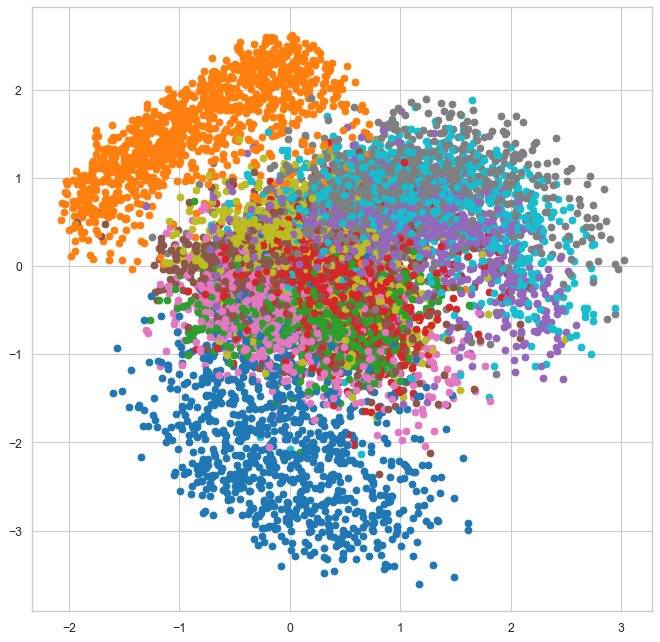

In [29]:
plt.figure(figsize=(10, 10), dpi=80)
for i, point in enumerate(mu_numpy[:]):
    nom = lab[i]
    plt.scatter(point[0],point[1],color = col[nom])
plt.show()

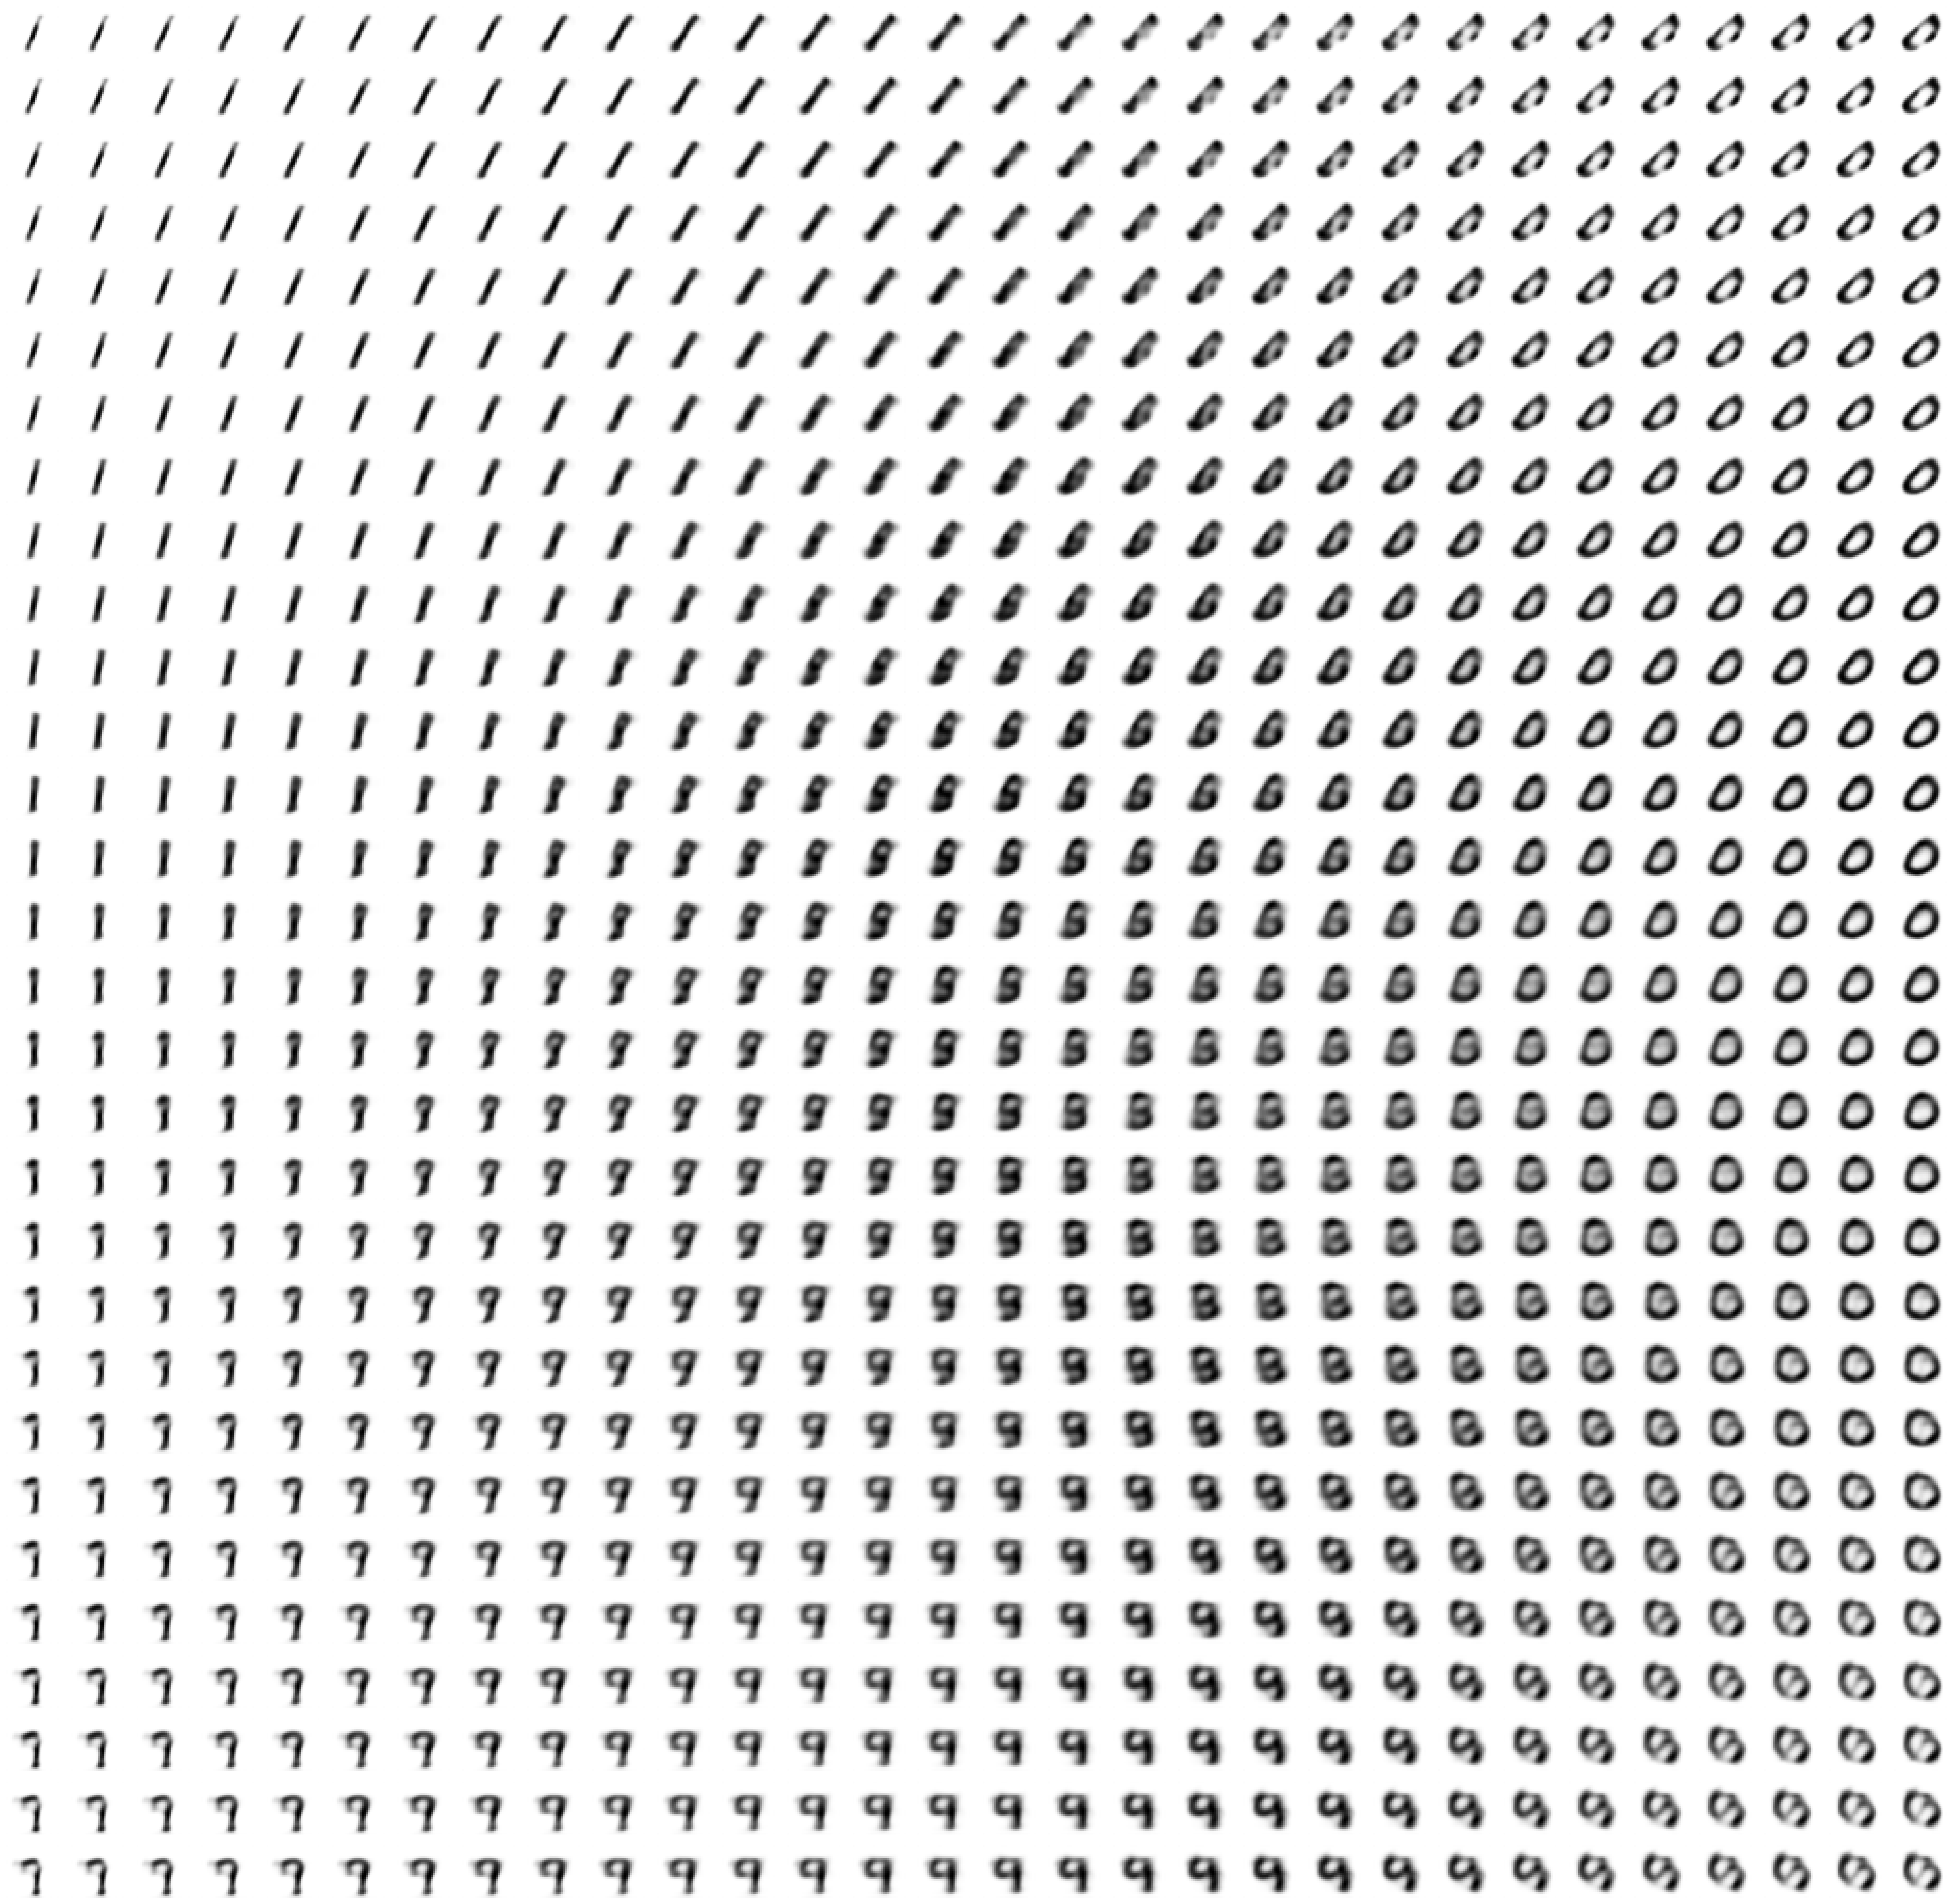

In [30]:
num = 0
N = 30
plt.figure(figsize=(30, 30), dpi=200)
for i in np.linspace(-2, 2, N, endpoint=True):
    for j in np.linspace(2, -2, N, endpoint=True):
        num += 1
        ax = plt.subplot(N, N, num)
        samples = 1 - torch.sigmoid(model.decoder(torch.Tensor([[i,j]]))).reshape(28,28)
        ax.imshow(samples.detach(), cmap='gray')
        ax.axis('off')